### Start to work on the uplaod

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

def parse_tcx_folder(folder_path):
    # Initialize an empty DataFrame to store all the data
    all_sessions_df = pd.DataFrame()

    # Iterate over all files in the directory
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tcx'):
            file_path = os.path.join(folder_path, file_name)
            tree = ET.parse(file_path)
            root = tree.getroot()

            namespaces = {'ns': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2'}

            data = []
            for trackpoint in root.findall('.//ns:Trackpoint', namespaces):
                time = trackpoint.find('ns:Time', namespaces).text
                elevation = trackpoint.find('ns:AltitudeMeters', namespaces)
                heart_rate = trackpoint.find('ns:HeartRateBpm/ns:Value', namespaces)
                latitude = trackpoint.find('ns:Position/ns:LatitudeDegrees', namespaces)
                longitude = trackpoint.find('ns:Position/ns:LongitudeDegrees', namespaces)

                data.append([
                    time,
                    float(elevation.text) if elevation is not None else np.nan,
                    int(heart_rate.text) if heart_rate is not None else np.nan,
                    float(latitude.text) if latitude is not None else np.nan,
                    float(longitude.text) if longitude is not None else np.nan,
                    file_name  # Add the filename as a new column
                ])

            df = pd.DataFrame(data, columns=['Time', 'Elevation', 'HeartRate', 'Latitude', 'Longitude', 'Filename'])
            df['Time'] = pd.to_datetime(df['Time'])  # Convert 'Time' to datetime

            # Append to the main DataFrame
            all_sessions_df = pd.concat([all_sessions_df, df])

    # Drop rows with any NaN values
    all_sessions_df = all_sessions_df.dropna()

    return all_sessions_df

# Example usage:
# folder_path = 'path_to_your_folder'
# combined_df = parse_tcx_folder(folder_path)
# print(combined_df)


In [3]:
from geopy.distance import geodesic

def calculate_velocity(df, window=1):
    """
    Calculate the velocity in meters per second given Latitude, Longitude, Elevation, and Time with varying intervals.
    Uses a rolling window to compute the average velocity over the specified window size.

    Parameters:
    - df: Pandas DataFrame with 'Time', 'Elevation', 'Latitude', and 'Longitude' columns
    - window: Size of the rolling window to average the velocity calculation

    Returns:
    - velocities: Numpy array of velocities in meters per second
    """

    # Convert Time column to datetime if not already
    df['Time'] = pd.to_datetime(df['Time'])

    # Calculate the difference between consecutive time points
    df['time_diff'] = df['Time'].diff().dt.total_seconds()

    # Initialize lists for distances and velocities
    velocities = []

    # Loop through each point in the DataFrame, applying the rolling window
    for i in range(window, len(df)):
        # Accumulate distances and time differences within the window
        distances = []
        time_diffs = []

        for j in range(i-window, i):
            prev_lat = df.iloc[j]['Latitude']
            prev_lon = df.iloc[j]['Longitude']
            prev_elev = df.iloc[j]['Elevation']

            curr_lat = df.iloc[j+1]['Latitude']
            curr_lon = df.iloc[j+1]['Longitude']
            curr_elev = df.iloc[j+1]['Elevation']

            # Calculate 2D distance between lat/long points
            prev_point = (prev_lat, prev_lon)
            curr_point = (curr_lat, curr_lon)
            distance_2d = geodesic(prev_point, curr_point).meters

            # Elevation difference
            elevation_diff = curr_elev - prev_elev

            # Total distance in 3D space
            distance_3d = np.sqrt(distance_2d**2 + elevation_diff**2)
            
            # Time difference
            time_diff = df.iloc[j+1]['time_diff']

            if time_diff > 0:
                velocity = distance_3d / time_diff
                distances.append(distance_3d)
                time_diffs.append(time_diff)

        # Average velocity over the window
        if distances and time_diffs:
            average_velocity = np.sum(distances) / np.sum(time_diffs)
        else:
            average_velocity = np.nan  # Handle cases with no valid data

        velocities.append(average_velocity)

    return np.array(velocities)


## upload files here

In [4]:
folder_path = '/Users/filippomichelon/Documents/PersonalCode/garmin_example_files'
df = parse_tcx_folder(folder_path)
df

,Time,Elevation,HeartRate,Latitude,Longitude,Filename
2,2024-08-16 16:38:27+00:00,843.000000,80,46.116021,11.168860,fil_0816.tcx
3,2024-08-16 16:38:28+00:00,842.400024,80,46.116059,11.168700,fil_0816.tcx
4,2024-08-16 16:38:34+00:00,842.799988,83,46.116105,11.168501,fil_0816.tcx
5,2024-08-16 16:38:37+00:00,843.799988,86,46.116080,11.168351,fil_0816.tcx
6,2024-08-16 16:38:38+00:00,844.000000,90,46.116065,11.168308,fil_0816.tcx
...,...,...,...,...,...,...
1965,2024-08-16 18:51:41+00:00,842.599976,166,46.116014,11.169224,fil_0816.tcx
1966,2024-08-16 18:51:54+00:00,842.200012,164,46.115922,11.169379,fil_0816.tcx
1967,2024-08-16 18:52:01+00:00,842.000000,161,46.115872,11.169466,fil_0816.tcx
1968,2024-08-16 18:52:05+00:00,842.000000,159,46.115853,11.169521,fil_0816.tcx


In [11]:
# calculate velocity

window_size = 5
velocities = calculate_velocity(df, window=window_size)


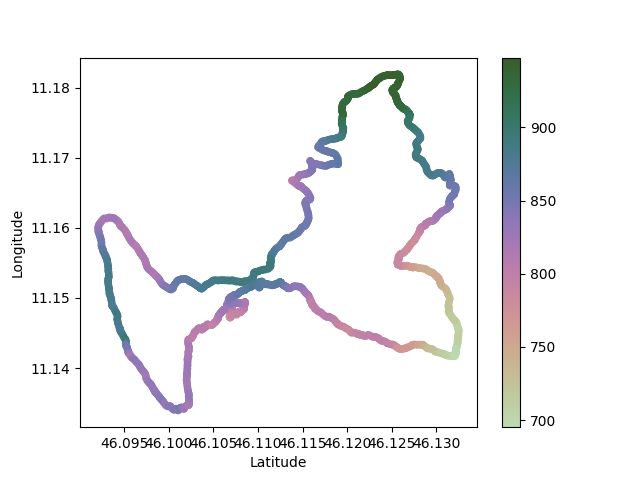

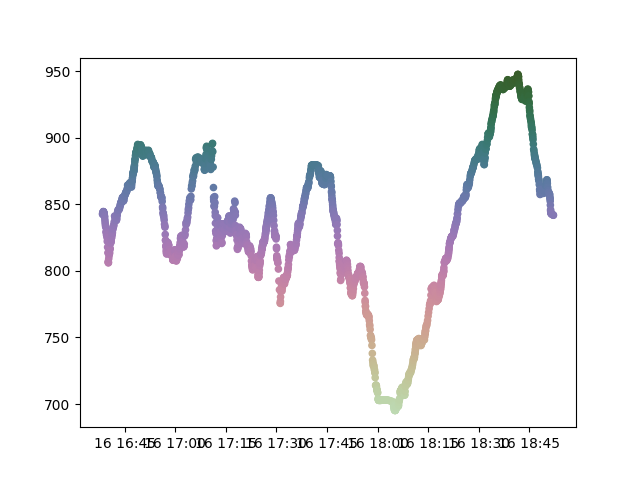

In [5]:
c = sns.cubehelix_palette(start=0, rot=2, dark=.3, light=.8, reverse=False, as_cmap=True)

plt.figure()
plt.scatter(df.Latitude, df.Longitude,20, c=df.Elevation, cmap=c)
plt.xlabel('Latitude'); plt.ylabel('Longitude')
plt.colorbar()

plt.figure()
plt.scatter(df.Time, df.Elevation,20,c=df.Elevation, cmap=c)


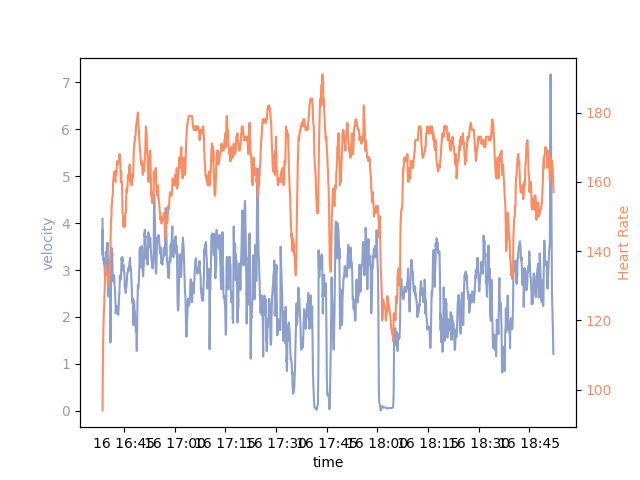

In [7]:
cvel = sns.color_palette("Set2")[2]
cheart = sns.color_palette("Set2")[1]


# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first dataset
ax1.plot(df.Time[window_size:], velocities,c = cvel)  # 'g-' is the color green with a solid line
ax1.set_xlabel('time')                   # Label for the x-axis
ax1.set_ylabel('velocity', color=cvel)     # Label for the y-axis of the first dataset
ax1.tick_params(axis='y', labelcolor=cvel)  # Set the color of the y-axis ticks

# Create a second y-axis
ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis

# Plot the second dataset
ax2.plot(df.Time[window_size:], df.HeartRate[window_size:], c = cheart)  # 'b--' is the color blue with a dashed line
ax2.set_ylabel('Heart Rate', color=cheart)     # Label for the y-axis of the second dataset
ax2.tick_params(axis='y', labelcolor=cheart)    # Set the color of the y-axis ticks


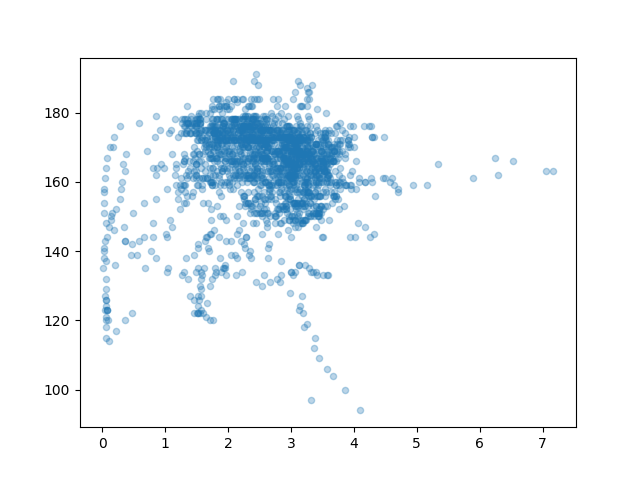

In [129]:
plt.figure()
plt.scatter(velocities,df.HeartRate[window_size:],20,alpha = .3)

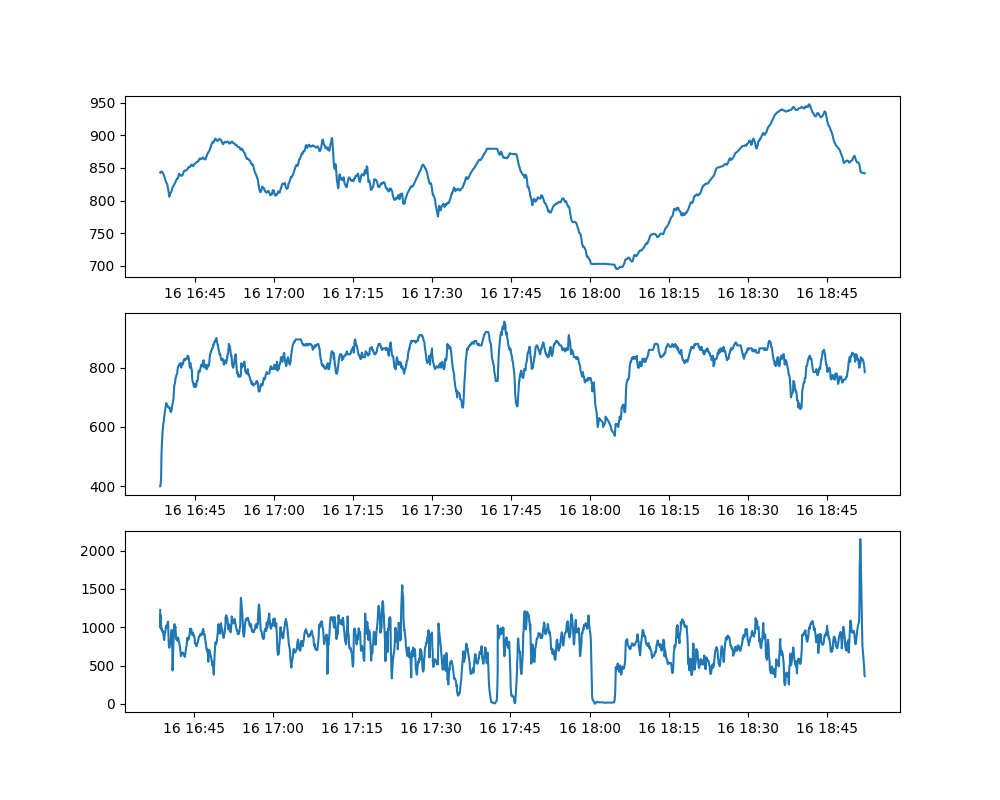

In [149]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))


axs[0].plot(df.Time,df.Elevation)
axs[1].plot(df.Time,df.HeartRate*5)
axs[2].plot(df.Time[window_size:],velocities*300)


(array([  3.,   2.,   1.,   2.,   2.,   2.,   6.,  25.,  13.,  46.,  29.,
         38., 115., 153., 325., 355., 503., 282.,  55.,  11.]),
 array([ 80.  ,  85.55,  91.1 ,  96.65, 102.2 , 107.75, 113.3 , 118.85,
        124.4 , 129.95, 135.5 , 141.05, 146.6 , 152.15, 157.7 , 163.25,
        168.8 , 174.35, 179.9 , 185.45, 191.  ]),
 <BarContainer object of 20 artists>)

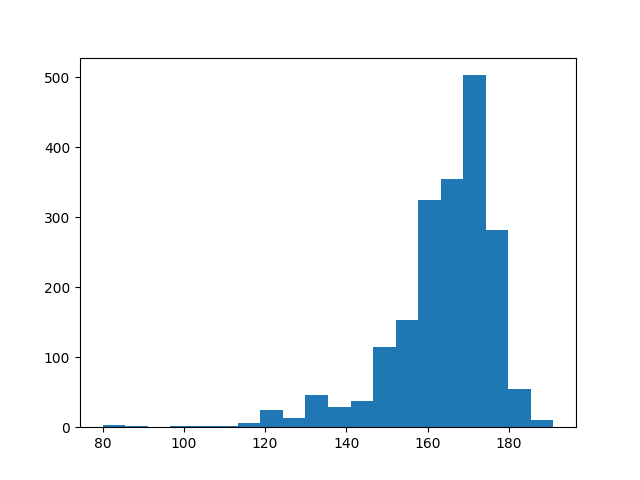

In [11]:
plt.figure()
plt.hist(df.HeartRate,20)

(array([638., 451., 609., 230.,  27.,   3.,   3.,   0.,   0.,   1.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([ 0.  ,  2.05,  4.1 ,  6.15,  8.2 , 10.25, 12.3 , 14.35, 16.4 ,
        18.45, 20.5 , 22.55, 24.6 , 26.65, 28.7 , 30.75, 32.8 , 34.85,
        36.9 , 38.95, 41.  ]),
 <BarContainer object of 20 artists>)

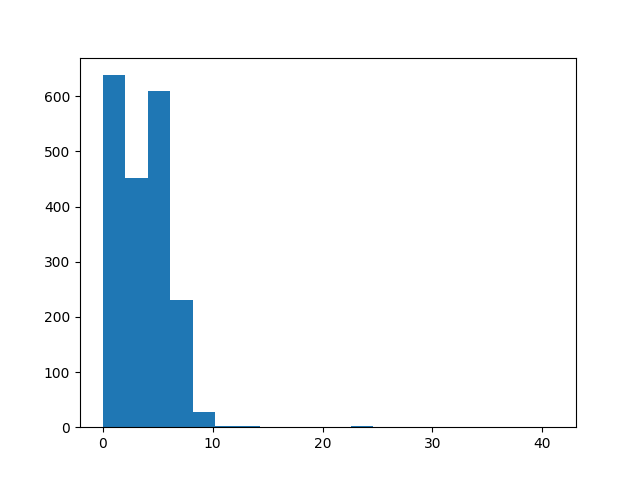

In [82]:


plt.figure()
plt.hist(df['Time'].diff().dt.total_seconds(),20)
